In [2]:
import os
import cv2
import numpy as np;
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import albumentations as album
import joblib

from scipy import ndimage
from typing import Tuple, List
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from caimages import *
import segmentation_models_pytorch.utils.metrics

## Define UNet Architecture

# Background is black, calcium is white
class_rgb_values = [(0,0,0), # black
(255, 255, 255) # white
]
class_names=['background', 'calcium']

x_train_dir=r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\unet_data\original\train"
y_train_dir=r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\unet_data\ground_truth\train"

x_valid_dir=r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\unet_data\original\valid"
y_valid_dir=r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\unet_data\ground_truth\valid"

x_test_dir=r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\unet_data\original\test"
y_test_dir=r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\unet_data\ground_truth\test"

# Get train and val dataset instances
train_full_dataset = CaImagesDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=class_rgb_values,
)
valid_full_dataset = CaImagesDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=class_rgb_values,
)
test_full_dataset = CaImagesDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),   
    class_rgb_values=class_rgb_values,
)

train_dataset = get_subset(train_full_dataset, 100)
valid_dataset = get_subset(valid_full_dataset, 10)
test_dataset = get_subset(test_full_dataset, 10)




# Get train and val data loaders (load large amounts of data more efficiently)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset)

print("Data loaders created.")

LOAD = False # True if loading a model, False if creating a new model
TRAINING = True # True if training, False if testing
load_num = 1
save_num = 1
target_width = 454 # change to max width of images in dataset (make sure dividable by 2)
target_height = 546 # change to max height of images in dataset

model_folder = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\models\unet"

Data loaders created.


In [9]:
TRAINING = True
LOAD = False

if TRAINING:
    if LOAD:
        model = joblib.load(f'{model_folder}/model{load_num}.pkl')
    else:
        model = UNet()

    print("Starting training...")
    EPOCHS = 1
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss = smp.utils.losses.DiceLoss()
    metrics = [
        smp.utils.metrics.IoU(threshold=0.5),
    ]
    optimizer = torch.optim.Adam([ 
        dict(params=model.parameters(), lr=0.00008),
    ])

    # define data loaders for training and validation sets
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )
    
    train_logs_list, valid_logs_list = [], [] # train and valid logs

    for i in range(0, EPOCHS):
        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
    
        joblib.dump(model, f'{model_folder}/model{save_num}.pkl')
else:
    model = joblib.load(f'{model_folder}/model{load_num}.pkl')


Starting training...

Epoch: 0
valid: 100%|██████████| 10/10 [03:25<00:00, 20.50s/it, dice_loss - 0.8479, iou_score - 0.0007584]


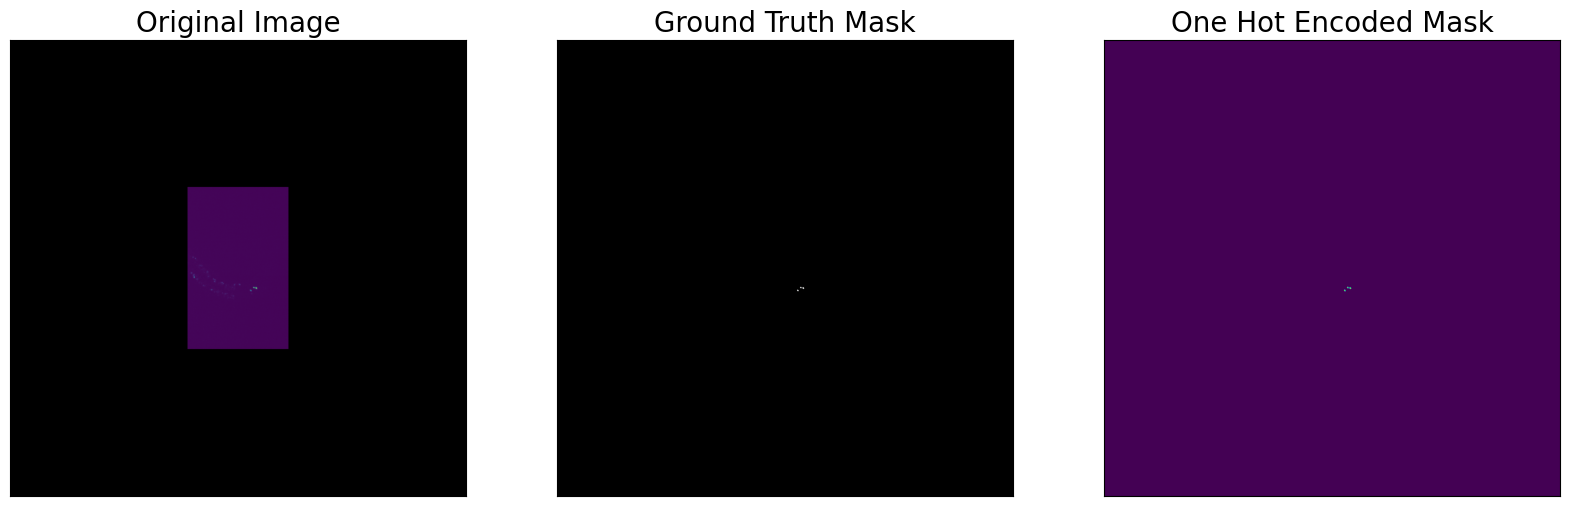

In [10]:
## Using Model to Perform Segmentation on Test Data

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = CaImagesDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]
visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)



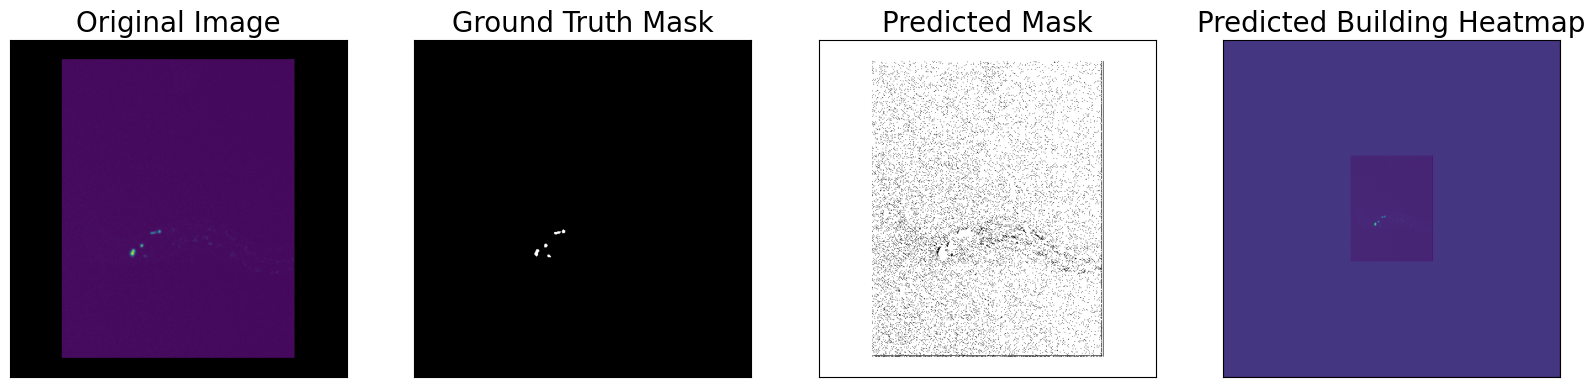

In [11]:
sample_preds_folder = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results\unet"


# for idx in range(len(test_dataset)):
random_idx = random.randint(0, len(test_dataset)-1)
image, gt_mask = test_dataset[random_idx] # image and ground truth from test dataset
image_vis = crop_image(np.transpose(test_dataset[random_idx][0].astype('uint8'), (1, 2, 0)), (target_height, target_width, 3)) # image for visualization
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

# Predict test image
pred_mask = model(x_tensor)
pred_mask = pred_mask.detach().squeeze().cpu().numpy()
# Convert pred_mask from `CHW` format to `HWC` format
pred_mask = np.transpose(pred_mask,(1,2,0))
# Get prediction channel corresponding to calcium
pred_calcium_heatmap = pred_mask[:,:,class_names.index('calcium')]
pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values), (target_height, target_width, 3))
# Convert gt_mask from `CHW` format to `HWC` format
gt_mask = np.transpose(gt_mask,(1,2,0))
gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values), (target_height, target_width, 3))

cv2.imwrite(
    os.path.join(sample_preds_folder, f"sample_pred_{i}.png"), 
    np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1]
    )  
visualize(
    original_image = image_vis,
    ground_truth_mask = gt_mask,
    predicted_mask = pred_mask,
    predicted_building_heatmap = pred_calcium_heatmap
)

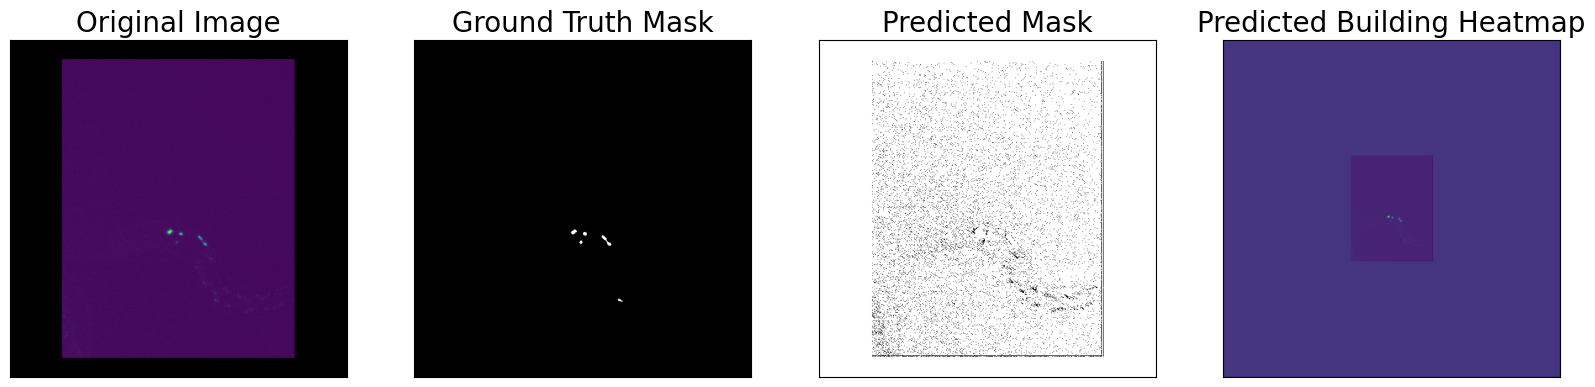

In [13]:
random_idx = random.randint(0, len(test_dataset)-1)
image, gt_mask = test_dataset[random_idx] # image and ground truth from test dataset
image_vis = crop_image(np.transpose(test_dataset[random_idx][0].astype('uint8'), (1, 2, 0)), (target_height, target_width, 3)) # image for visualization
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

# Predict test image
pred_mask = model(x_tensor)
pred_mask = pred_mask.detach().squeeze().cpu().numpy()
# Convert pred_mask from `CHW` format to `HWC` format
pred_mask = np.transpose(pred_mask,(1,2,0))
# Get prediction channel corresponding to calcium
pred_calcium_heatmap = pred_mask[:,:,class_names.index('calcium')]
pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values), (target_height, target_width, 3))
# Convert gt_mask from `CHW` format to `HWC` format
gt_mask = np.transpose(gt_mask,(1,2,0))
gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values), (target_height, target_width, 3))

cv2.imwrite(
    os.path.join(sample_preds_folder, f"sample_pred_{i}.png"), 
    np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1]
    )  
visualize(
    original_image = image_vis,
    ground_truth_mask = gt_mask,
    predicted_mask = pred_mask,
    predicted_building_heatmap = pred_calcium_heatmap
)

In [12]:

### Evaluating Test Metrics

test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid:  40%|████      | 4/10 [01:25<02:08, 21.45s/it, dice_loss - 0.8479, iou_score - 0.0009431]


KeyboardInterrupt: 

# Load model

In [14]:
model = joblib.load(f'{model_folder}/model1.pkl')

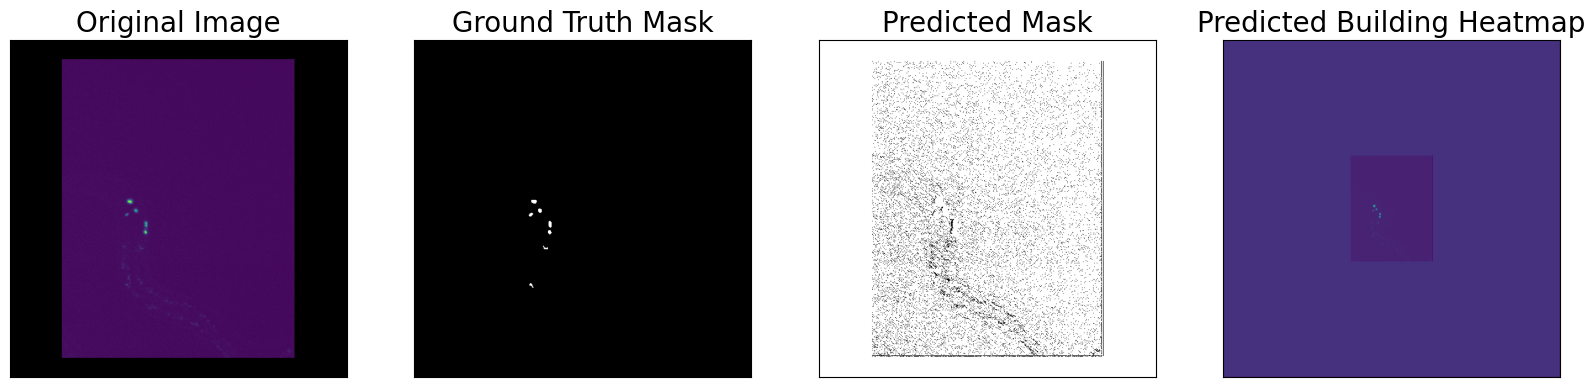

In [15]:
random_idx = random.randint(0, len(test_dataset)-1)
image, gt_mask = test_dataset[random_idx] # image and ground truth from test dataset
image_vis = crop_image(np.transpose(test_dataset[random_idx][0].astype('uint8'), (1, 2, 0)), (target_height, target_width, 3)) # image for visualization
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

# Predict test image
pred_mask = model(x_tensor)
pred_mask = pred_mask.detach().squeeze().cpu().numpy()
# Convert pred_mask from `CHW` format to `HWC` format
pred_mask = np.transpose(pred_mask,(1,2,0))
# Get prediction channel corresponding to calcium
pred_calcium_heatmap = pred_mask[:,:,class_names.index('calcium')]
pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values), (target_height, target_width, 3))
# Convert gt_mask from `CHW` format to `HWC` format
gt_mask = np.transpose(gt_mask,(1,2,0))
gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values), (target_height, target_width, 3))

cv2.imwrite(
    os.path.join(sample_preds_folder, f"sample_pred_{i}.png"), 
    np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1]
    )  
visualize(
    original_image = image_vis,
    ground_truth_mask = gt_mask,
    predicted_mask = pred_mask,
    predicted_building_heatmap = pred_calcium_heatmap
)